In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# Import PreTrained Models

In [ ]:
fcn_model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
fcn_model.eval()
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()
mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 121MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecat

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Set the Threshlods

In [ ]:
detection_threshlod = 0.7
mask_threshlod = 0.7

# Function to process images and show the segmentation

In [ ]:
def process_image(image, model_fcn,model_faster_rcnn, model_mask_rcnn):
  transform = transforms.Compose([
      transforms.ToTensor() #convert image to a pytorch tensor
  ])
  image_tensor = transform(image)

  #FCN Semantic Segmentation
  with torch.no_grad():
    output_fcn = model_fcn(image_tensor.unsqueeze(0))
    output_fcn_predictions = output_fcn['out'].argmax(dim=1).squeeze(0).cpu().numpy()

  with torch.no_grad():
    output_frcnn = model_faster_rcnn([image_tensor])

    #Mask R-CNN
  with torch.no_grad():
    output_maskrcnn = model_mask_rcnn([image_tensor])

  #extra boxes labels and masks from faster rcnn and mask rcnn output

  boxes_frcnn = output_frcnn[0]['boxes'].cpu().numpy()
  labels_frcnn = output_frcnn[0]['labels'].cpu().numpy()
  scores_frcnn = output_frcnn[0]['scores'].cpu().numpy()

  masks = output_maskrcnn[0]['masks'].cpu().numpy()
  boxes_maskrcnn = output_maskrcnn[0]['boxes'].cpu().numpy()
  scores_maskrcnn = output_maskrcnn[0]['labels'].cpu().numpy()

  #plot the original image fcn segmentation output, faster rcnn detections and mask rcnn masks
  fig, ax=plt.subplots(1,4,figsize=(20,5))
  #original Image

  ax[0].imshow(image)
  ax[0].set_title('Original Image')
  ax[0].axis('off')

  #FCN Semantic Segmentation
  ax[1].imshow(output_fcn_predictions)
  ax[1].set_title('FCN Semantic Segmentation')
  ax[1].axis('off')

  #faster rcnn object detection (filtered by threshold)
  ax[2].imshow(image)
  for i, box in enumerate(boxes_frcnn):
    if scores_frcnn[i]> detection_threshlod:
      xmin, ymin, ymax, xmax = box
      rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor='red', linewidth=2)
      ax[2].add_patch(rect)

  ax[2].set_title('Faster RCNN Object Detection\n (Threshold= {detection_threshold})')
  ax[2].axis('off')
  #mask rcnn segmentation (filtered by threshold)
  ax[3].imshow(image)
  for i, box in enumerate(boxes_maskrcnn):
    if scores_maskrcnn[i]> mask_threshlod:
      xmin, ymin, ymax, xmax = box
      mask = masks[i,0]
      mask = mask > mask_threshlod #apply mask threshold
      ax[3].imshow(mask,alpha=0.5)

  ax[3].set_title(f'Mask R-CNN Segmentation\n (Threshold= {mask_threshlod})')
  ax[3].axis('off')

  plt.tight_layout()
  plt.show()

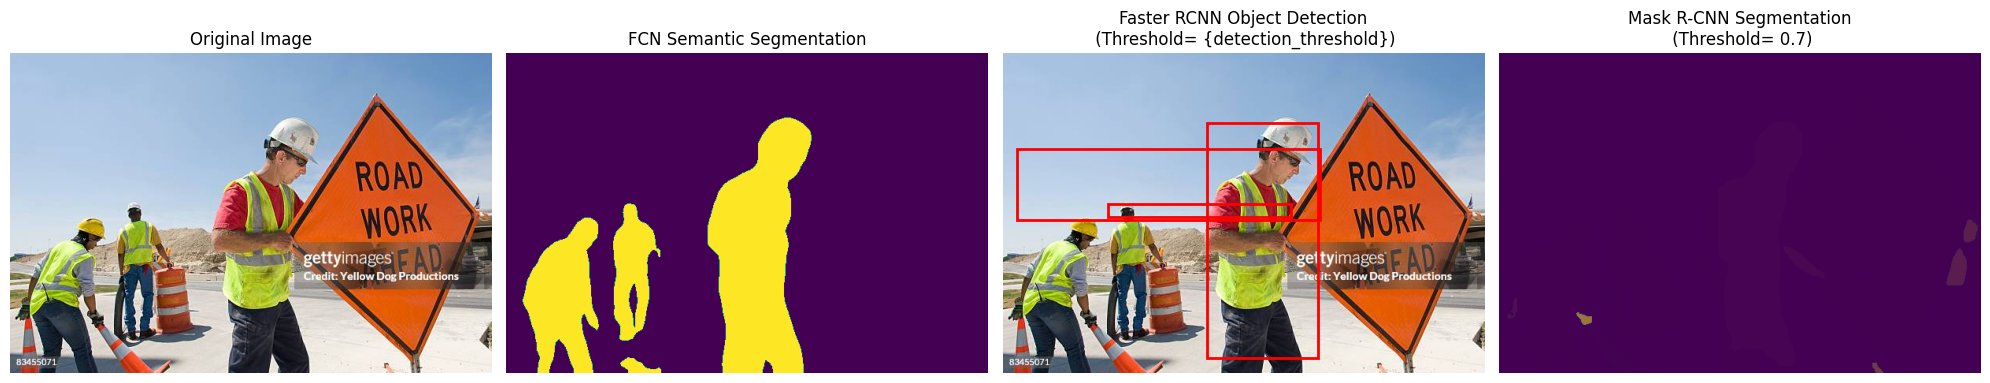

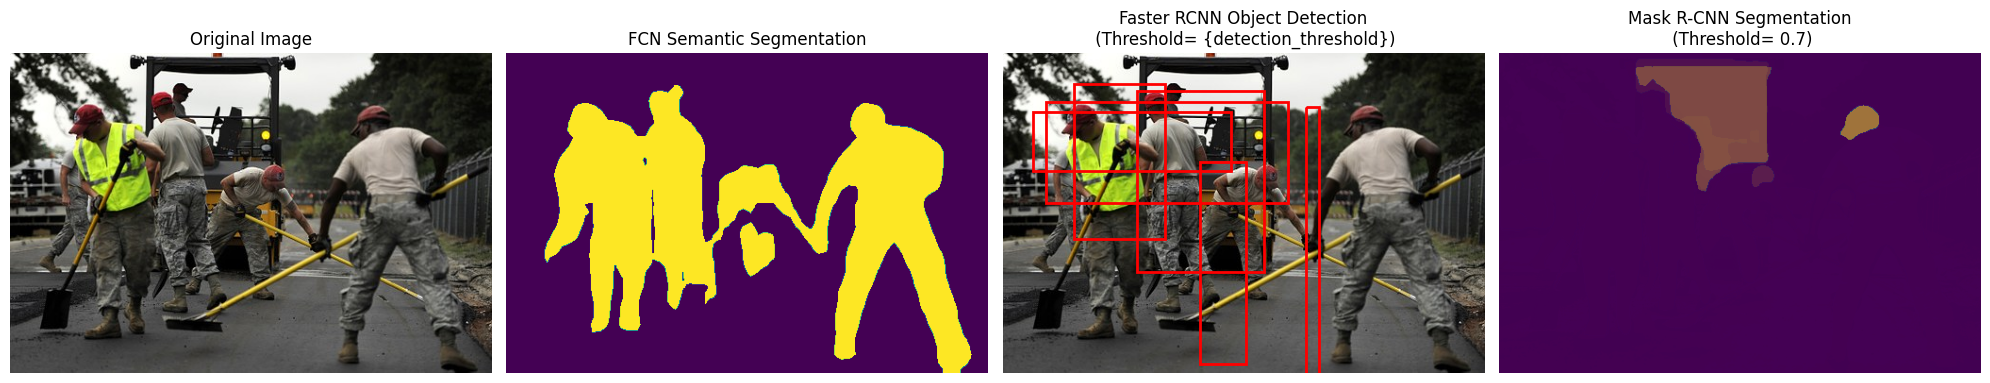

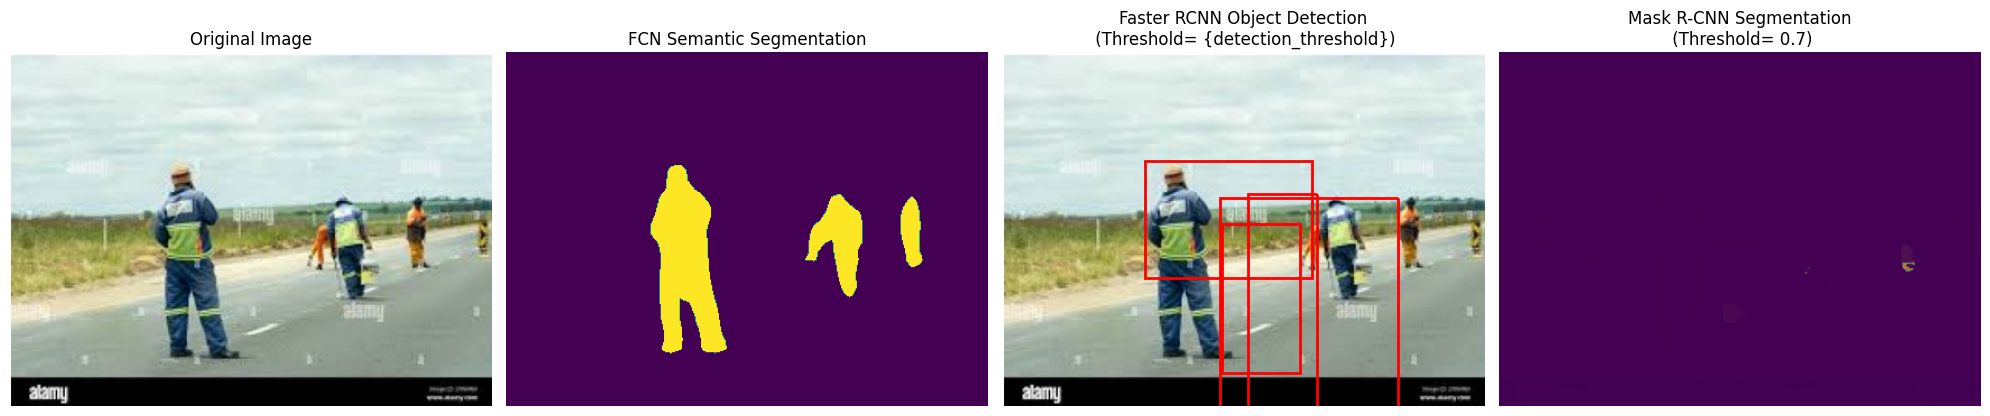

In [ ]:
#Load your images
road_image = Image.open('road.jpg')
road2_image = Image.open('road2.jpg')
road3_image = Image.open('road3.jpg')
#car_image = Image.open('car.jpg')
#car2_image = Image.open('car2.jpg')

#Process each image with the models
process_image(road_image, fcn_model, faster_rcnn_model, mask_rcnn_model)
process_image(road2_image, fcn_model, faster_rcnn_model, mask_rcnn_model)
process_image(road3_image, fcn_model, faster_rcnn_model, mask_rcnn_model)
#process_image(car_image, fcn_model, faster_rcnn_model, mask_rcnn_model)
#process_image(car2_image, fcn_model, faster_rcnn_model, mask_rcnn_model)